# Prototype 01
#### Tasks
##### Done

- Check timos epsilon decay strategy [✓]
- Split the dataset presented to each client [✓]
- Check the format of training data [✓]
- Add softmax to the last layer [✓] 
- Make function to save the most important details about an experiment in a README.md file and save it with the models and the graphics [✓]
- Improve the log experiment function [✓]
- Check why the learning curve shows twice as many epochs as actually existent [✓]
- Add saving functionality to the plotting functions [✓]
- write the experiment summary directly into the md file [✓]
- Add the global training time and the round training time [✓]
- Add a name function to the agent and make the global agent return the correct name [✓]
- Check why there is twice as many episodes in the graph as there should be [✓]
- Align the markdown table to the left [✓]
- Save the full training time [✓]
- Save the rount training time on each client [✓]
- Add the execution date to the experiment report [✓]
- Use the pipe table [✓]
- How many threads can my macbook pro run in parallel => 6 (12 with Hyperthreadding) [✓]
- Check if the experiment directory already exists and if yest delete it and make space for the new files [✓]
- Check different types of tables [✓]
- Remove the verbosity flag from the server train functions [✓]
- Change the blue in the graphics to a darker blue and the red to a more poppy color. [✓]
- Make a subindex possible for the experiment [✓]
- Check if the replay memoery init can be moved internally (client_01.init_replay_memory(MIN_REPLAY_SIZE)) [✓]
- Check that the test data is independant from the train data [✓]
- Validate the copying of the parameters works properly [✓]
- Weight aggregation does not take a lot of time [✓]
- incorporate the confusion matrix [✓].
- Check why there is 4 output actions and not 5 [✓]
- Check why the parallelized training is not faster? [✓]
- Better split the training data to clients [✓]
- Check RMS Prop [✓]
- Parallelize the training [✓]
- How often do i have to initialze the replay memory? [✓]
- Move the training to the GPU. => Not necessary since training time is not the biggest bottleneck [✓]
- What is the purpose of share memory function?
- Check why there is 4 actions (possible outputs) of the DQN while we only use 3 MTDs. Does zero mean no MTD? [✓]
- What is the purpose of share memory function? [✓]
- Fixed the epsilon decay [✓]

##### Open

- Check different federated aggregation strategies for class distinct problems
- Ipmlemtne Multiclass Imbalance Degree (MID) Metric
- Print a graph with overall attack detection accuracy (How many got mitigated and how many did not get mitigated)
- Check which loss we are using (purpose of binary cross entropy loss)
- Maybe we should use the model with the best test performance as aggregation strategy
- Make graphs that cover the global test accuracy over all rounds for all clients (including the global agent)
- Make a historgram of samples chosen in each round and a historgram of sample classes chosen over the whole training
- Check hyperparameter search
- Write down all hyperparamters

## Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

## Training on Local Machine

In [2]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01


In [3]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [4]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [5]:
# Validate that python 3.10 is used
!python --version

Python 3.10.10


In [6]:
def seed_random():
    random.seed(42)
    torch.random.manual_seed(42)
    np.random.seed(42)

## --- Dependencies ---

In [7]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [8]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.data_provider import DataProvider
#from src.agent import Agent
#from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent_on_afterstates

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## --- Hyperparameters ---

In [9]:
# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.0001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4

## --- Source ---

In [10]:
def split_training_data(training_data, n_strides):
    strides = []
    for i in range(n_strides):
        strides.append(dict())

    for key, value in training_data.items():
        #print(f"{key} => {len(value)}")
        array_split = np.array_split(value, n_strides)
        for i in range(n_strides):
            strides[i][key] = array_split[i]
        
    return stridesap

In [30]:
from typing import Dict, Tuple, List
from src.custom_types import Behavior, MTDTechnique, actions, supervisor_map
import numpy as np
import random


# handles the supervised, online-simulation of episodes
class SensorEnvironment:

    def __init__(self, train_data: Dict[Behavior, np.ndarray] = None, sample_distribution: Dict[Behavior, int] = None):
        #print("Recognized Behaviours")
        #print(train_data.keys())
        self.train_data = train_data
        
        #sum_of_percentages = reduce(lambda x, y: x+y, sample_distribution.values())
        #assert sum_of_percentages == 100, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"
        self.sample_distribution = sample_distribution
        
        self.current_state: np.array = None
        self.observation_space_size: int = len(self.train_data[Behavior.NORMAL][0][:-1])
        self.actions: List[int] = [i for i in range(len(actions))]

    # Returns a randomly selected attack state with non normal behaviour.
    def sample_random_attack_state(self):
        if self.sample_distribution != None:
            behaviors = list(self.sample_distribution.keys())
            attacks = [b for b in behaviors if b != Behavior.NORMAL]
            attacks = behaviors
            sampling_probabilities = self.sample_distribution.values()
            sampled_attack = random.choices(attacks, weights=sampling_probabilities, k=1)[0]
            attack_states = self.train_data[sampled_attack]
            return attack_states[np.random.randint(attack_states.shape[0], size=1), :]
        else:
            sampled_attack = random.choice([b for b in self.train_data.keys() if b != Behavior.NORMAL])

        attack_states = self.train_data[sampled_attack]
        return attack_states[np.random.randint(attack_states.shape[0], size=1), :]
    
    # Return random sample with specified behaviour
    def sample_behavior(self, b: Behavior):
        behavior_data = self.train_data[b]
        return behavior_data[np.random.randint(behavior_data.shape[0], size=1), :]


    def step(self, action: int):
        current_behavior = self.current_state.squeeze()[-1]

        if current_behavior in supervisor_map[action]:
            # print("correct mtd chosen according to supervisor")
            new_state = self.sample_behavior(Behavior.NORMAL)
            reward = self.calculate_reward(True)
            isTerminalState = True
        else:
            # print("incorrect mtd chosen according to supervisor")
            new_state = self.sample_behavior(current_behavior)
            reward = self.calculate_reward(False)
            isTerminalState = False

        self.current_state = new_state
        return new_state, reward, isTerminalState

    def reset(self):
        self.current_state = self.sample_random_attack_state()
        return self.current_state

    # TODO: possibly adapt to distinguish between MTDs that are particularly wasteful in case of wrong deployment
    def calculate_reward(self, success):
        """
        this method can be refined to distinguish particularly wasteful MTDs (i.e. Dirtrap penalized harder than rootkit sanitization)
        """
        if success:
            return 1
        else:
            return -1

In [12]:
from typing import Dict
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from deep_q_network import DeepQNetwork
import copy

class Agent:
    def __init__(self, agent_id: int, input_dims: int, n_actions, batch_size,
                 lr, gamma, epsilon, eps_end=0.02, eps_dec=1e-4, buffer_size=100000, is_global_agent=False, osiose=False):
        self.agent_id = agent_id
        self.is_global_agent = is_global_agent
        #self.verbose = verbose
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_max = epsilon # Initial epsilon value
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.total_accuracies = {}
        self.mean_class_accuracies = {}

        self.episode_action_memory = set()
        self.replay_buffer = deque(maxlen=buffer_size)
        self.reward_buffer = deque([0.0], maxlen=100)  # for printing progress

        self.batch_size = batch_size

        self.online_net = DeepQNetwork(lr, n_actions=n_actions,
                                       input_dims=input_dims,
                                       fc1_dims=60, fc2_dims=30)
        self.target_net = DeepQNetwork(lr, n_actions=n_actions,
                                       input_dims=input_dims,
                                       fc1_dims=60, fc2_dims=30)
        self.target_net.load_state_dict(self.online_net.state_dict())

    def choose_action(self, observation):
        try:
            if np.random.random() > self.epsilon:
                #
                action = self.take_greedy_action(observation)
                if action in self.episode_action_memory:
                    action = np.random.choice(list(set(self.action_space).difference(self.episode_action_memory)))
            else:
                action = np.random.choice(list(set(self.action_space).difference(self.episode_action_memory)))
            self.episode_action_memory.add(action)
        except ValueError:
            return -1
        return action

    def take_greedy_action(self, observation):
        state = torch.from_numpy(observation.astype(np.float32)).to(self.online_net.device)
        actions = self.online_net.forward(state)
        action = torch.argmax(actions).item()
        return action

    def learn(self):
        # init data batch from memory replay for dqn
        transitions = random.sample(self.replay_buffer, self.batch_size)
        b_obses = np.stack([t[0].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_actions = np.asarray([t[1] for t in transitions]).astype(np.int64)
        b_rewards = np.asarray([t[2] for t in transitions]).astype(np.int16)
        b_new_obses = np.stack([t[3].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_dones = np.asarray([t[4] for t in transitions]).astype(np.int16)
        t_obses = torch.from_numpy(b_obses).to(self.target_net.device)
        t_actions = torch.from_numpy(b_actions).to(self.target_net.device)
        t_rewards = torch.from_numpy(b_rewards).to(self.target_net.device)
        t_new_obses = torch.as_tensor(b_new_obses).to(self.target_net.device)
        t_dones = torch.as_tensor(b_dones).to(self.target_net.device)

        # compute targets
        target_q_values = self.target_net(t_new_obses)
        max_target_q_values = torch.max(target_q_values, dim=1)[0]

        targets = (t_rewards + self.gamma * (1 - t_dones) * max_target_q_values).unsqueeze(1)

        # compute loss
        q_values = self.online_net(t_obses)
        taken_action_q_values = torch.gather(input=q_values, dim=1, index=t_actions.unsqueeze(1))

        loss = self.online_net.loss(taken_action_q_values, targets).to(self.target_net.device)

        # gradient descent
        self.online_net.optimizer.zero_grad()
        loss.backward()
        self.online_net.optimizer.step()

        new_epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        # epsilon decay
        #print(f"{self.get_name()}: {round(self.epsilon, 4)}->{round(new_epsilon, 4)}")
        #self.epsilon = new_epsilon

    def epsilon_decay(self, nr_trained_episodes):
        #print(f"Episode {nr_trained_episodes} => {self.epsilon}")
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def get_weights(self):
        return copy.deepcopy(self.target_net.state_dict())
    
    def update_weights(self, model_params):
        #start_time = time_ns()
        self.online_net.load_state_dict(copy.deepcopy(model_params))
        self.target_net.load_state_dict(copy.deepcopy(model_params))
        #end_time = time_ns()
        #time_difference = end_time - start_time
        #print(f"Updating weights on {self.get_name()} took {time_difference / 10**9}s")
        
    def get_name(self):
        if self.agent_id == 0:
            return "Global Agent"
        else:
            return f"Agent {self.agent_id}"
    
    def save_agent_state(self, n: int, directory: str):
        torch.save({
            'online_net_state_dict': self.online_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'batch_size': self.batch_size,
            'replay_buffer': self.replay_buffer,
            'reward_buffer': self.reward_buffer,
            'action_space': self.action_space,
            'gamma': self.gamma,
            'eps': self.epsilon,
            'eps_min': self.eps_min,
            'eps_dec': self.eps_dec,
            'lr': self.lr
        }, f"{directory}/trained_models/agent_{n}.pth")

        #torch.save(self.online_net.state_dict(), f"offline_prototype_2_raw_behaviors/trained_models/online_net_{n}.pth")
        #torch.save(self.target_net.state_dict(), f"offline_prototype_2_raw_behaviors/trained_models/target_net_{n}.pth")

In [13]:
import os
import torch
from torch import nn, optim
import copy
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.pyplot as plt
from time import time, time_ns
#from agent import Agent
from sensor_environment import SensorEnvironment
from src.custom_types import MTDTechnique, Behavior

#%matplotlib inline

class Client:
        # memory buffer is influenced by env.step -> resetting to previous action, which may result in unbalanced training
    def __init__(self, client_id: int, agent: Agent, environment: SensorEnvironment, save_path="",  min_replay_size=100):
        self.client_id = client_id
        self.agent = agent
        self.environment = environment
        self.episode_returns = [] 
        self.eps_history = []
        self.save_path = save_path
        self.start_time = 0
        self.end_time = 0
        self.nr_trained_episodes=0
        
        # initialize replay memory
        self.init_replay_memory(min_replay_size)
    
    def init_replay_memory(self, min_size):
        obs = self.environment.reset()
        episode_action_memory = []
        i = 0
        while i < min_size:
            try:
                action = np.random.choice(list({0,1,2,3}.difference(episode_action_memory)))
                episode_action_memory.append(action)
            except ValueError:
                obs = self.environment.reset()
                episode_action_memory = []
                # results in slightly less entries than min_size
                print("exhausted all mtd techniques")
                continue
            i += 1

            new_obs, reward, done = self.environment.step(action)
            idx1 = -1 if obs[0, -1] in Behavior else -2
            idx2 = -1 if new_obs[0, -1] in Behavior else -2
            transition = (obs[:, :idx1], action, reward, new_obs[:, :idx2], done)
            self.agent.replay_buffer.append(transition)

            obs = new_obs
            if done:
                obs = self.environment.reset()
                episode_action_memory = []

                
    def train_agent(self, num_episodes, t_update_freq=100, verbose=False):
        self.start_time = time()
        step = 0
        for num_episode in range(num_episodes):
            self.nr_trained_episodes+=1
            
            episode_return = 0
            episode_steps = 0
            done = False
            obs = self.environment.reset()
            while not done:
                idx1 = -1 if obs[0, -1] in Behavior else -2
                action = self.agent.choose_action(obs[:, :idx1])
                if action == -1:
                    print("Agent exhausted all MTD techniques upon behavior: ", obs[0, -1])
                    self.agent.episode_action_memory = set()
                    done = True
                    continue

                new_obs, reward, done = self.environment.step(action)
                idx2 = -1 if new_obs[0, -1] in Behavior else -2
                episode_return += reward
                self.agent.replay_buffer.append((obs[:, :idx1], action, reward,
                                            new_obs[:, :idx2], done))
                self.agent.reward_buffer.append(reward)
                if done:
                    self.agent.episode_action_memory = set()

                self.agent.learn()
                obs = new_obs

                episode_steps += 1
                # update target network
                step += 1
                if step % t_update_freq == 0:
                    self.agent.update_target_network()

            self.episode_returns.append(episode_return / episode_steps)
            self.eps_history.append(self.agent.epsilon)
            self.agent.epsilon_decay(self.nr_trained_episodes)
         
        self.end_time = time() 
        #print(f"The total training time on {self.agent.get_name()} ({num_episodes}) was {self.get_training_time()}s")
        
    
    def receive_weights(self, model_params):
        self.agent.update_weights(model_params)
        
    def get_weights(self):
        return self.agent.get_weights()
    
    def get_training_summary(self):
        return self.episode_returns, self.eps_history
    

    def plot_learning_curve(self, filename, nr_round: int):
        title = f"Learning Curve until Round {nr_round} on Client {self.client_id}"
        returns =  []
        epsilons = []
        returns, epsilons = self.get_training_summary()

        assert len(returns) == len(epsilons)
        x = [i + 1 for i in range(len(returns))]
        fig = plt.figure()

        ax = fig.add_subplot(111, label="1")
        ax2 = fig.add_subplot(111, label="2", frame_on=False)
        ax.set_title(title)

        color_1 = "red"
        ax.plot(x, epsilons, color=color_1)
        ax.set_xlabel("Episode", color='black')
        ax.set_ylabel("Epsilon", color=color_1)
        ax.set_ylim([0, 1])
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors=color_1)
        
        N = len(returns)
        running_avg = np.empty(N)
        for t in range(N):
            running_avg[t] = np.mean(returns[max(0, t - 20):(t + 1)])
        
        color_2 = "blue"
        ax2.scatter(x, running_avg, color=color_2, s=2 ** 2)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.yaxis.tick_right()
        ax2.set_ylabel('Average Return', color=color_2)
        ax2.set_ylim([0, 1])
        ax2.yaxis.set_label_position('right')
        ax2.tick_params(axis='y', colors=color_2)

        if self.save_path:
            if not os.path.isdir(self.save_path):
                os.makedirs(self.save_path)
            filepath = os.path.join(self.save_path, filename)
            plt.savefig(filepath)
            
        plt.show()
        
    def get_training_time(self):
        return self.end_time - self.start_time
    
    def plot_training_data_split(self):
        D = {}
        for key, value in self.environment.train_data.items():
            name = str(key).split('.')[1]
            D[name] = len(value)
        
        plt.bar(range(len(D)), list(D.values()), align='center', color='blue')
        plt.xticks(range(len(D)), list(D.keys()))
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Behavior Distribution on Client {self.client_id}")
        plt.ylabel('n_samples')
        
        filename = f"behavior_sample_distribution_on_client-{self.client_id:02d}.png"
        filepath = os.path.join(self.save_path, filename)
        plt.savefig(filepath, bbox_inches="tight")
        plt.show()
        
    #def plot_performance_curve():
        

In [77]:
#from prototypes.prototype_01.sensor_environment import SensorEnvironment
#from prototypes.prototype_01.agent import Agent
#from prototypes.prototype_01.client import Client

In [14]:
import os

def print_process_ids():
    pid = os.getpid()
    ppid = os.getppid()

    print("Parent Process ID of current process:", ppid)
    print("Process ID of current process:", pid)
    
print_process_ids()

Parent Process ID of current process: 43707
Process ID of current process: 43724


In [15]:
from enum import Enum, auto

class Execution(Enum):
    SEQUENTIAL = auto()
    MULTI_THREADED = auto()
    MULTI_PROCESSING = auto()
    MULTI_PROCESSING_POOL = auto()

In [16]:
from enum import Enum, auto

class Evaluation(Enum):
    TRAINING_TIME = auto()
    LEARNING_CURVE = auto()
    TEST_ACCURACY = auto()
    PERFORMANCE_EVALUATION = auto()
    CONFUSION_MATRIX = auto()
    BEHAVIOR_ACTION_EVALUATION = auto()

In [17]:
#NR_ROUNDS = 10
#NR_EPISODES_PER_ROUND = 1000
import torch
from torch import nn
import copy
from time import time, time_ns
from src.custom_types import Behavior, MTDTechnique, actions, supervisor_map

from typing import List, Dict
import threading
import numpy as np
import json
from tabulate import tabulate
from datetime import date
from src.custom_types import MTDTechnique, Behavior
#from multiprocessing import Process
import multiprocessing

class Server:
    def __init__(self, global_agent: Agent, test_data, experiment_id, save_path, nr_rounds = NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND):
        self.clients = []
        self.global_agent = global_agent
        self.test_data = test_data
        self.save_path = save_path
        self.experiment_id = experiment_id
        self.file_path = os.path.join(save_path, f"experiment-{experiment_id:02d}_summary.md")
        self.nr_rounds = nr_rounds
        self.nr_epochs_per_round = nr_episodes_per_round
        #self.parallelized = parallelized
        self.total_training_time = None
        self.round_training_times = []

        self.performance_evaluations = {}
        self.performance_evaluations[0] = {}
        self.performance_evaluations["rounds"] = []
        for behavior in Behavior:
            self.performance_evaluations[0][behavior] = []
        
        
    def aggregate_weights(self):
        client_parameters = {client.client_id: client.get_weights() for client in self.clients}
        client_weight = 1/len(self.clients)
        
        aggregated_weights = copy.deepcopy(next(iter(client_parameters.values())))  # names
        for parameter_name in aggregated_weights:
            aggregated_weights[parameter_name] = torch.zeros(aggregated_weights[parameter_name].shape)
        for client_parameter in client_parameters.values():
            for parameter_name in aggregated_weights:
                aggregated_weights[parameter_name] += client_parameter[parameter_name] * client_weight  # averaging

        self.global_agent.update_weights(aggregated_weights)
        
        
    def broadcast_weights(self):
        for client in self.clients:
            client.receive_weights(self.global_agent.get_weights())

    def add_client(self, client: Client):
        self.clients.append(client)
        
        self.performance_evaluations[client.client_id] = {}
        for behavior in Behavior:
            self.performance_evaluations[client.client_id][behavior] = []
    
    

    def run_federation(self, execution=Execution.SEQUENTIAL, evaluations=[], evaluation_frequency: int = 10, verbose=True, document_results=True):
        if Evaluation.TRAINING_TIME in evaluations:
            start_time = time()
        
        if document_results:
            self.document("")
            self.document(f"# Prototype 1 (Experiment {self.experiment_id})")
            self.document("---")
            self.document("")
            self.document(f"Executed on {date.today().strftime('%d.%m.%Y')}")
            self.save_experiment_summary()
        
        for nr_round in range(1, self.nr_rounds+1):
            if nr_round % evaluation_frequency == 0:
                if document_results:
                    self.document("")
                    self.document('<div style="page-break-after: always;"></div>')
                    self.document("")
                    self.document("---")
                    self.document(f"### Training Round {nr_round}/{self.nr_rounds}")
                    self.document("")

            if verbose:
                print(f">>> SERVER TRAINING ROUND {nr_round}/{self.nr_rounds} <<<")
                
            for client in self.clients:
                client.receive_weights(self.global_agent.get_weights())
                   
            match execution:
                case Execution.MULTI_THREADED:
                    threads = []
                    for client in self.clients:
                        #client.agent.online_net.share_memory()
                        t = threading.Thread(target=Client.train_agent, args=(client, self.nr_epochs_per_round))
                        t.start()
                        threads.append(t)
                        
                    for t in threads:
                        t.join()
                        
                        
                case Execution.MULTI_PROCESSING:
                    threads = []
                    for client in self.clients:
                        thread = multiprocessing.Process(target=Client.train_agent, args=(client, self.nr_epochs_per_round))  
                        thread.start()
                        threads.append(thread)

                    for thread in threads:
                        thread.join() 
                       
                    
                case Execution.MULTI_PROCESSING_POOL:
                    pool = multiprocessing.Pool(processes=len(self.clients))
                    pool.starmap(Client.train_agent, map(lambda client: (client, self.nr_epochs_per_round), self.clients))
                    pool.close()
                    pool.join()
                    
                    
                case _:
                    for client in self.clients:
                        client.train_agent(self.nr_epochs_per_round)
                    
                    
            self.aggregate_weights()
            if nr_round % evaluation_frequency == 0:
                self.performance_evaluations['rounds'].append(nr_round)
                for client in self.clients:
                    self.document(f"- Training Round {nr_round} on Client {client.client_id} took {round(client.get_training_time(), 2)}s")
                
                if Evaluation.LEARNING_CURVE in evaluations:
                    for client in self.clients:
                        filename = f"round-{self.prefix(nr_round)}_agent-{(client.client_id):02d}_learning-curve.png"
                        client.plot_learning_curve(filename, nr_round)
                        self.document(f"![graph]({filename})")
                
                agents = list(map(lambda client: client.agent, server.clients))
                agents.append(global_agent)
                for agent in agents:
                    #print(f"\n=== {client.agent.get_name()} - Evaluation ===\n")
                    if Evaluation.PERFORMANCE_EVALUATION in evaluations:
                        self.performance_evaluation(agent, self.test_data, nr_round)
                    if Evaluation.CONFUSION_MATRIX in evaluations:
                        self.confusion_matrix(agent, self.test_data)
                    if Evaluation.BEHAVIOR_ACTION_EVALUATION in evaluations:
                        self.behavior_action_evaluation(agent, self.test_data)

                #print(f"\n=== {self.global_agent.get_name()} - Evaluation ===\n")
                #if Evaluation.PERFORMANCE_EVALUATION in evaluations:
                #    self.performance_evaluation(self.global_agent, self.test_data, nr_round)
                #if Evaluation.CONFUSION_MATRIX in evaluations:
                #    self.confusion_matrix(self.global_agent, self.test_data)
                #if Evaluation.BEHAVIOR_ACTION_EVALUATION in evaluations:
                #    self.behavior_action_evaluation(self.global_agent, self.test_data)
        
            if Evaluation.TRAINING_TIME in evaluations:
                round_time = time()
                time_elapsed = round_time - start_time
                self.round_training_times.append(time_elapsed)
                #print(f"Total time elapsed until end of round {nr_round}: {time_elapsed}s")    
        
        if Evaluation.TRAINING_TIME in evaluations:
            end_time = time()
            total_training_time = end_time - start_time
            print(f"Total training time with {len(self.clients)} clients: {total_training_time}")
            self.total_training_time = total_training_time
            
            if document_results:
                self.document(f"\n ### Total training time with {len(self.clients)}: {round(total_training_time, 2)}s")
             
    def final_training_accuracy(self):
        #list(my_dict.values())[-1]
        final_training_accuracy = list(self.global_agent.total_accuracies.values())[-1]
        final_mean_class_accuracy = list(self.global_agent.mean_class_accuracies.values())[-1]
        return final_training_accuracy, final_mean_class_accuracy
    
    def document(self, text):
        text = text.replace("_", "\_")
        if self.save_path:
            with open(self.file_path,'a') as f:
                # Add newline to text
                text += "  \n"
                f.write(text)   
                
    def document_block(self, text):
        text = text.replace("_", "\_")
        if self.save_path:
            with open(self.file_path,'a') as f:
                # Add newline to text
                text += "\n \n  \n \n"
                f.write(text)  
                            
                    
    def prefix(self, round: int): 
        prefix_length = len(str(self.nr_rounds))
        return f"{round:0{prefix_length}d}"

    def plot_learning_curves(self):
        for client in self.clients:
            episode_returns, eps_history = client.get_training_summary()
            plot_learning_curve(f"{client.client_id}", episode_returns, eps_history)
            
    def save_experiment_summary(self):
        experiment_summary = {}
        self.document("## Configuration")
        self.document("### Server")
        self.document(f"- nr_clients: {len(self.clients)}")
        self.document(f"- nr_rounds: {self.nr_rounds}")
        self.document(f"- nr_epochs_per_round: {self.nr_epochs_per_round}")
        #self.document(f"- parallelized: {self.parallelized}")
        self.document("")
        
        for client in self.clients:
            self.document(f"### Client {client.client_id}")
            self.document(f"- gamma: {client.agent.gamma}")
            self.document(f"- learning_rate: {client.agent.lr}")
            self.document(f"- batch_size: {client.agent.batch_size}")
            self.document(f"- epsilon_max: {client.agent.eps_max}")
            self.document(f"- epsilon_min: {client.agent.eps_min}")
            self.document(f"- epsilon_decay: {client.agent.eps_dec}")
            self.document(f"- input_dims: {client.agent.input_dims}")
            self.document(f"- output_dims: {client.agent.n_actions}")
            self.document("")

            self.document(f"Training Data Split")
            for key, value in client.environment.train_data.items():
                self.document(f"- {len(value)} samples of {key}")
                
            #client.plot_training_data_split()
            #self.document(f"![](behavior_sample_distribution_on_client-{client.client_id:02d}.png)")
            
        self.document(f"### Global Agent") 
        self.document(f"- id: {self.global_agent.agent_id}")
        self.document(f"- batch_size: {self.global_agent.batch_size}")
        self.document(f"- epsilon: 0")
        self.document(f"- batch_size: {self.global_agent.input_dims}")
        self.document(f"- batch_size: {self.global_agent.n_actions}")

            
    def performance_evaluation(self, agent: Agent, test_data, nr_round):
        # check predictions with learnt dqn
        agent.online_net.eval()
        res_dict = {}
        objective_dict = {}
        with torch.no_grad():
            for b, d in test_data.items():
                if b != Behavior.NORMAL:
                    cnt_corr = 0
                    cnt = 0
                    for state in d:
                        action = agent.take_greedy_action(state[:-1])
                        if b in supervisor_map[action]:
                            cnt_corr += 1
                        cnt += 1
                    res_dict[b] = (cnt_corr, cnt)

                for i in range(len(actions)):
                    if b in supervisor_map[i]:
                        objective_dict[b] = actions[i]
        labels = ("Behavior", "Accuracy", "Objective")
        results = []
        
        total_accuracy, mean_class_accuracy = self.compute_accuracies(res_dict)
        agent.total_accuracies[nr_round] = total_accuracy
        agent.mean_class_accuracies[nr_round] = mean_class_accuracy
        
        for behavior, t in res_dict.items():
            #print("---")
            #print(f"behavior: {behavior} {behavior.value}")
            accuracy = t[0] / t[1] * 100
            accuracy_in_percent = round(accuracy, 2)
            #print(f"accuracy_in_percent: {accuracy_in_percent}")
            self.performance_evaluations[agent.agent_id][behavior].append(accuracy_in_percent)
            results.append((behavior.value, accuracy_in_percent, objective_dict[behavior].value))

        self.document(f"\n\n{agent.get_name()}\n")
        self.document(tabulate(results, headers=labels, tablefmt="pipe"))

        #print(f"{agent.get_name()} > Performance Evaluation")
        #print(tabulate(results, headers=labels, tablefmt="pipe"))
    
    def compute_accuracies(self, res_dict):
        class_accuracies = []
        number_correctly_classified = 0
        number_total_samples = 0

        for (class_correct, class_total) in res_dict.values():
            class_accuracy = class_correct/class_total
            class_accuracies.append(class_accuracy)

            number_correctly_classified+=class_correct
            number_total_samples+=class_total

        total_accuracy = number_correctly_classified/number_total_samples
        mean_class_accuracy = np.mean(class_accuracies, axis=0)
        return total_accuracy, mean_class_accuracy
        print(f"Total Accuracy: {round(total_accuracy*100, 2)}%")
        print(f"Mean Class Accuracy: {round(mean_class_accuracy*100, 2)}%")
    
    def confusion_matrix(self, agent: Agent, test_data):
        agent.online_net.eval()
        confusion_matrix = np.zeros((4,4))
          
        with torch.no_grad():
            for behavior, state_samples in test_data.items():
                if behavior != Behavior.NORMAL:
                    for state_sample in state_samples:
                        a_pred = agent.take_greedy_action(state_sample[:-1])
                        if behavior in supervisor_map[a_pred]:
                               confusion_matrix[a_pred][a_pred] +=1
                        else:
                            leftover_actions = [i for i in range(4) if i != a_pred]
                            for leftover_action in leftover_actions:
                                if behavior in supervisor_map[leftover_action]:
                                   confusion_matrix[leftover_action][a_pred] +=1
          
        mtds = list(map(lambda x: x.value, actions))
        results = np.concatenate((np.array(mtds).reshape((-1, 1)), confusion_matrix), axis=1)
        labels = ["MTD_true/ MTD_pred"] + mtds
        print("")
        print(f"{agent.get_name()} > Confusion Matrix")
        print(tabulate(results, headers=labels, tablefmt="pipe"))
        
    def behavior_action_evaluation(self, agent: Agent, test_data):
        n_behaviors = len(Behavior) - 1
        n_actions = len(actions)
        matrix = np.zeros((n_behaviors, n_actions))
        
        behavior_action_counts = {}
        for behavior in Behavior:
            if behavior != Behavior.NORMAL:
                behavior_action_counts[behavior] = np.zeros((1, n_actions))
        
        with torch.no_grad():
            for behavior, state_samples in test_data.items():
                if behavior != Behavior.NORMAL:
                    for state_sample in state_samples:
                        a_pred = agent.take_greedy_action(state_sample[:-1])
                        behavior_action_counts[behavior][0][a_pred]+=1
          
        labels = ["behavior"] + list(map(lambda x: x.value, actions))
        
        results = np.empty((0, n_actions+1))
        for behavior, action_counts in behavior_action_counts.items():
            row = np.append(np.array([behavior]).reshape(-1, 1), action_counts, axis=1)
            results = np.concatenate((results, row), axis=0)
        
        print(f"\n{agent.get_name()} > Behavior Action Evaluation")
        print(tabulate(results, headers=labels, tablefmt="pipe"))

        
    def print_performance_evaluations(self):
        for behavior in Behavior:
            for id in range(len(self.clients)+1):
                performance = self.performance_evaluations[id][behavior]
                rounds = self.performance_evaluations['rounds']
                plt.title(f"Mitigation Accuracy for {behavior}")
                plt.ylim([0,100])
                if id == 0:
                    plt.plot([*range(len(performance))], performance, linestyle='-', label=f"Global Agent") # plotting t, a separately 
                else:
                    plt.plot([*range(len(performance))], performance, linestyle='--', label=f"Agent {id}") # plotting t, a separately 
            plt.xlabel('Round')
            plt.ylabel('Accuracy [%]')
            plt.show()

In [99]:
x = np.array([1,2,3])

In [100]:
np.append(x, 4)

array([1, 2, 3, 4])

In [101]:
print(x)

[1 2 3]


In [ ]:
print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")

In [18]:
import os
import shutil

class Experiment:
    def __init__(self, base_path):
        self.base_path = base_path
        
    def get_experiment_path(self, experiment_id, experiment_version=0):
        path = os.path.join(self.base_path, f"experiments/experiment_{experiment_id:02d}")
        if experiment_version != 0:
            path = os.path.join(path, f"version_{experiment_version:02d}")
            
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            shutil.rmtree(path)          
            os.makedirs(path)
            
        return path

In [57]:
print(round(0.000, 4))

0.0001


-----------
## --- Experiments ---
### Experiment 01

In [ ]:
import math

experiments = Experiment(original_working_directory_path)
experiment_id = 10
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

TOTAL_NUMBER_OF_EPISODES = 10000
NR_ROUNDS = 10
#NR_CLIENTS = [2**i for i in range(0,4)]
NR_CLIENTS = list(range(1,11))

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

total_training_times = {}
round_training_times = {}

for execution in [Execution.SEQUENTIAL, Execution.MULTI_THREADED]:
    total_training_times[execution] = {}
    round_training_times[execution] = {}
    for nr_clients in NR_CLIENTS:
        
        nr_episodes_per_round = math.floor(TOTAL_NUMBER_OF_EPISODES / (NR_ROUNDS * nr_clients))
        
        print(f"nr_clients: {nr_clients}; execution: {execution}; nr_episodes_per_round: {nr_episodes_per_round}")

        environment = SensorEnvironment(train_data)
        global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
        # We want to train for n episodes when adding all episodes across all clients and rounds
        
        server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=nr_episodes_per_round)

        for unique_id in range(1, nr_clients + 1):
            environment = SensorEnvironment(train_data)
            agent = Agent(unique_id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)                               
            client = Client(unique_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)                                   
            server.add_client(client)

        server.run_federation(evaluations=[Evaluation.TRAINING_TIME, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1, verbose=True, document_results=False)
        total_training_times[execution][nr_clients] = server.total_training_time
        round_training_times[execution][nr_clients] = server.round_training_times

In [96]:
#flattend_test_data = np.empty([0,47])
#for behavior_data in test_data.values():
#    flattend_test_data = np.concatenate((flattend_test_data, behavior_data), axis=0)
#
#print(flattend_test_data[:10]])

In [ ]:
import math

experiments = Experiment(original_working_directory_path)
experiment_id = 10
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

TOTAL_NUMBER_OF_EPISODES = 10000
NR_ROUNDS = 10
#NR_CLIENTS = [2**i for i in range(0,4)]
NR_CLIENTS = list(range(1,11))

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

total_training_times = {}
round_training_times = {}

for execution in Execution:
    total_training_times[execution] = {}
    round_training_times[execution] = {}
    for nr_clients in NR_CLIENTS:
        
        nr_episodes_per_round = math.floor(TOTAL_NUMBER_OF_EPISODES / (NR_ROUNDS * nr_clients))
        
        print(f"nr_clients: {nr_clients}; execution: {execution}; nr_episodes_per_round: {nr_episodes_per_round}")

        environment = SensorEnvironment(train_data)
        global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
        # We want to train for n episodes when adding all episodes across all clients and rounds
        
        server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=nr_episodes_per_round)

        for unique_id in range(1, nr_clients + 1):
            environment = SensorEnvironment(train_data)
            agent = Agent(unique_id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)                               
            client = Client(unique_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)                                   
            server.add_client(client)

        server.run_federation(evaluations=[Evaluation.TRAINING_TIME], evaluation_frequency=10, verbose=False, document_results=False)
        total_training_times[execution][nr_clients] = server.total_training_time
        round_training_times[execution][nr_clients] = server.round_training_times

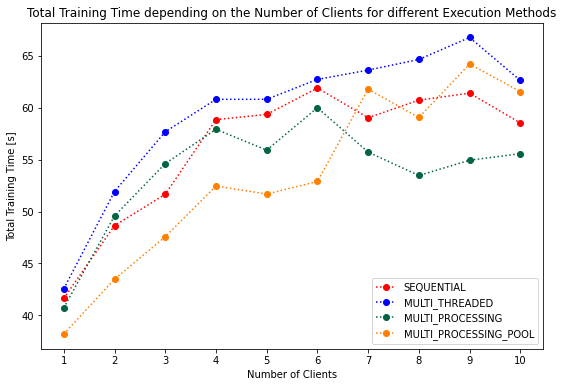

In [113]:
import matplotlib.pyplot as plt

training_execution_times = {
    Execution.SEQUENTIAL: {1: 41.64533591270447, 2: 48.645366191864014, 3: 51.65800380706787, 4: 58.84803819656372, 5: 59.35266900062561, 6: 61.889692068099976, 7: 59.03123378753662, 8: 60.72743010520935, 9: 61.397526025772095, 10: 58.53206706047058}, 
    Execution.MULTI_THREADED: {1: 42.561840295791626, 2: 51.92962908744812, 3: 57.67661094665527, 4: 60.804693937301636, 5: 60.808934020996094, 6: 62.72223496437073, 7: 63.61850380897522, 8: 64.643840074539185, 9: 66.76117181777954, 10: 62.622076988220215},
    Execution.MULTI_PROCESSING: {1: 40.726606130599976, 2: 49.579752922058105, 3: 54.61402606964111, 4: 57.9219069480896, 5: 55.913047075271606, 6: 59.99676012992859, 7: 55.721699237823486, 8: 53.472405195236206, 9: 54.939626932144165, 10: 55.5736198425293}, 
    Execution.MULTI_PROCESSING_POOL: {1: 38.21208715438843, 2: 43.48049211502075, 3: 47.57568597793579, 4: 52.455981969833374, 5: 51.68520402908325, 6: 52.89683985710144, 7: 61.78531098365784, 8: 59.05573129653931, 9: 64.20857810974121, 10: 61.55194592475891}
}

colors = {
    Execution.SEQUENTIAL: '#FF0000',
    Execution.MULTI_THREADED: '#0000FF' ,
    Execution.MULTI_PROCESSING: '#026440', 
    #Execution.MULTI_PROCESSING_POOL: '#FFD700',
    Execution.MULTI_PROCESSING_POOL: '#FF8000',
}


plt.figure(figsize=(9,6))
xlabel = "Number of Clients"
ylabel = "Total Training Time"
plt.xlabel(xlabel)
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} depending on the {xlabel} for different Execution Methods")
plt.xticks(np.arange(1, 11, 1))
#plt.figure(facecolor='white')
for execution_type, execution_times in training_execution_times.items():
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker='o', linestyle='dotted', label=execution_type.name, color=colors[execution_type])
#plt.plot(list(single_threaded_training_times.keys()), list(single_threaded_training_times.values()), color="#FF0000", marker='o', linestyle='dashed', label='single-threaded')
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/total_training_time_anaylsis_different_execution_methods.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

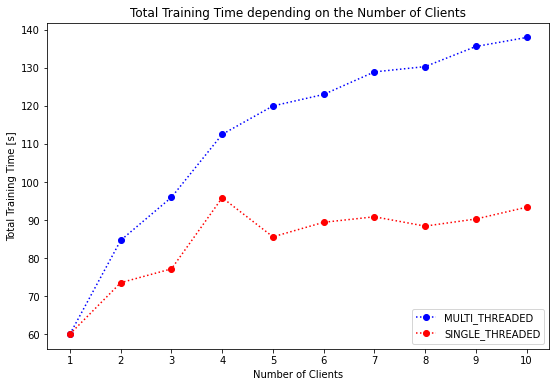

In [109]:
training_execution_times = {
    Execution.MULTI_THREADED: {1: 60.096912240982056, 2: 84.69177293777466, 3: 95.97647094726562, 4: 112.5046796798706, 5: 119.96393752098083, 6: 122.97974967956543, 7: 128.90417885780334, 8: 130.29015493392944,9: 135.57496786117554, 10: 137.94399547576904},
    Execution.SEQUENTIAL: {1: 60.085861587524414, 2: 73.55881094932556, 3: 77.18544721603394, 4: 95.86744952201843, 5: 85.5958263874054, 6: 89.41081714630127, 7: 90.85983729362488, 8: 88.41040182113647, 9: 90.274986743927, 10: 93.36574625968933}
}

colors = {
    Execution.SEQUENTIAL: '#FF0000',
    Execution.MULTI_THREADED: '#0000FF' ,
}

labels = {
    Execution.SEQUENTIAL: 'SINGLE_THREADED',
    Execution.MULTI_THREADED: 'MULTI_THREADED',
}

plt.figure(figsize=(9,6))
xlabel = "Number of Clients"
ylabel = "Total Training Time"
plt.xlabel(xlabel)
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} depending on the {xlabel}")
plt.xticks(np.arange(1, 11, 1))
#plt.figure(facecolor='white')
for execution_type, execution_times in training_execution_times.items():
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker='o', linestyle='dotted', label=labels[execution_type], color=colors[execution_type])
#plt.plot(list(multi_threaded_training_times.keys()), list(multi_threaded_training_times.values()), color="#0000FF", marker='o', linestyle='dashed', label='multi-threaded')
#plt.plot(list(single_threaded_training_times.keys()), list(single_threaded_training_times.values()), color="#FF0000", marker='o', linestyle='dashed', label='single-threaded')
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/total_training_time_anaylsis.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

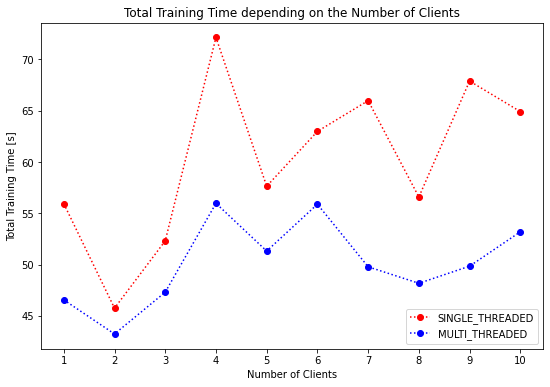

In [42]:
# When running the same experiment again after removing the call client.agent.online_net.share_memory()
# the result looks quite different
# Suddenly the multi threaded execution is much faster and even undercuts the sequential execution time
training_execution_times = {
    Execution.SEQUENTIAL: {1: 55.936387062072754, 2: 45.74790716171265, 3: 52.31152296066284, 4: 72.1409330368042, 5: 57.63561201095581, 6: 62.982574701309204, 7: 65.98179888725281, 8: 56.5855827331543, 9: 67.89041876792908, 10: 64.91327786445618}, 
    Execution.MULTI_THREADED: {1: 46.55751991271973, 2: 43.2324378490448, 3: 47.306280851364136, 4: 55.97371578216553, 5: 51.31317400932312, 6: 55.885953187942505, 7: 49.78178310394287, 8: 48.173242807388306, 9: 49.84343409538269, 10: 53.19402813911438}
}

colors = {
    Execution.SEQUENTIAL: '#FF0000',
    Execution.MULTI_THREADED: '#0000FF' ,
}

labels = {
    Execution.SEQUENTIAL: 'SINGLE_THREADED',
    Execution.MULTI_THREADED: 'MULTI_THREADED',
}

plt.figure(figsize=(9,6))
xlabel = "Number of Clients"
ylabel = "Total Training Time"
plt.xlabel(xlabel)
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} depending on the {xlabel}")
plt.xticks(np.arange(1, 11, 1))
#plt.figure(facecolor='white')
for execution_type, execution_times in training_execution_times.items():
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker='o', linestyle='dotted', label=labels[execution_type], color=colors[execution_type])
#plt.plot(list(multi_threaded_training_times.keys()), list(multi_threaded_training_times.values()), color="#0000FF", marker='o', linestyle='dashed', label='multi-threaded')
#plt.plot(list(single_threaded_training_times.keys()), list(single_threaded_training_times.values()), color="#FF0000", marker='o', linestyle='dashed', label='single-threaded')
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/total_training_time_anaylsis.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

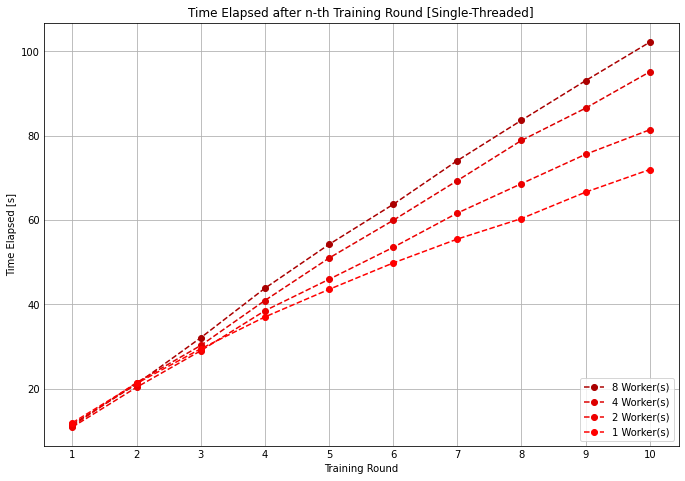

In [180]:
import matplotlib.pyplot as plt

single_threaded_training_times = {
    8: [11.481971979141235, 21.06865358352661, 32.05444097518921, 43.78777265548706, 54.19769239425659, 63.688286542892456, 74.07056212425232, 83.64049768447876, 93.04087591171265, 102.16776514053345],
    4: [11.134565114974976, 21.432404279708862, 30.219168186187744, 40.88900446891785, 50.95054054260254, 59.90651512145996, 69.32415723800659, 78.86217856407166, 86.5220353603363, 95.12839889526367],
    2: [10.868289709091187, 20.302647829055786, 28.97062063217163, 38.460485219955444, 45.914576292037964, 53.48994708061218, 61.6273672580719, 68.60588765144348, 75.56985259056091, 81.3848009109497],
    1: [11.893369436264038, 21.207906484603882, 29.435447692871094, 36.99051022529602, 43.52670192718506, 49.79359436035156, 55.46211814880371, 60.33178234100342, 66.59190773963928, 71.95667171478271]
}

colors = {
    1: "#FF0000",
    2: "#EE0000",
    4: "#DD0000",
    8: "#AA0000"
}

n_samples = len(single_threaded_training_times)
n_rounds = len(single_threaded_training_times[1])

plt.figure(figsize=(9,6))
xlabel = "Training Round"
ylabel = "Time Elapsed"
plt.xlabel(xlabel)
plt.xticks(np.arange(1, n_rounds+1))
plt.ylabel(f"{ylabel} [s]")
plt.title(f"{ylabel} after n-th {xlabel} [Single-Threaded]")

for number_of_workers, training_times in single_threaded_training_times.items():
    plt.plot(list(range(1,n_rounds+1)), list(training_times), color=colors[number_of_workers], marker="o", linestyle='dashed', label=f"{number_of_workers} Worker(s)")
plt.legend(loc ="lower right")
plt.savefig("prototypes/prototype_01/round_training_time_analysis.jpg", dpi=150, bbox_inches = "tight", transparent=False)
plt.show()

-----------
### --- Experiment 02 ---

In [ ]:
import matplotlib.pyplot as plt

experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)
 
EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

behavior_subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK)
training_data_subset_1 = {x: training_data[x] for x in behavior_subset_1 if x in training_data}
environment_01 = SensorEnvironment(training_data_subset_1)

behavior_subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1, Behavior.CNC_OPT2)
training_data_subset_2 = {x: training_data[x] for x in behavior_subset_2 if x in training_data}
environment_02 = SensorEnvironment(training_data_subset_2)

datasets = {
    "Global Behavior Distribution": training_data, 
    "Behavior Distribution on Client 1": training_data_subset_1,
    "Behavior Distribution on Client 2": training_data_subset_2
}

for title, dataset in datasets.items():
    sample_distribution = {behavior: 0 for behavior in Behavior}
    for k, v in dataset.items():
         sample_distribution[k] = len(v)

    plt.bar(range(len(sample_distribution)), list(sample_distribution.values()), align='center', color='blue')
    plt.xticks(range(len(sample_distribution)), list(sample_distribution.keys()))
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel('n_samples')
    plt.savefig(f"{title}.jpg", bbox_inches="tight")
    plt.show()



global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

#server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.TIME], evaluation_frequency=1, verbose=True, document_results=True)

In [311]:
a = [[i]*8 for i in range(1,101)]
m = np.asarray(a)
#np.asarray(a)
np.random.shuffle(m)
last_row = m[-1]
new_matrix = m[:-1]

In [252]:
for key, value in train_data.items():
    print(len(value))

9633
6196
3405
4723
4941
2391
3632
2533


In [ ]:
for id in range(3):
    for behavior in Behavior:
        performance = server.client_performance[id][behavior]
        plt.title(f"Client {id}")
        plt.plot([*range(len(performance))], performance) # plotting t, a separately 
    plt.show()

In [ ]:
for behavior in Behavior:
    for id in range(3):
        performance = server.client_performance[id][behavior]
        plt.title(f"Behavior {behavior.value}")
        plt.ylim([0,100])
        if id == 0:
            plt.plot([*range(len(performance))], performance, linestyle='-') # plotting t, a separately 
        else:
            plt.plot([*range(len(performance))], performance, linestyle='--') # plotting t, a separately 
    plt.show()

-----------
### Experiment 02

In [125]:
experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, 2)

environment_01 = SensorEnvironment(training_data_strides[0])
environment_02 = SensorEnvironment(training_data_strides[1])

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


NameError: name 'stridesap' is not defined

In [52]:
training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

sampling_probabilities = {
    Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.1,
    Behavior.ROOTKIT_BEURK: 0.2,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.2,
    Behavior.CNC_THETICK: 0.1, 
    Behavior.CNC_OPT1: 0.1,
    Behavior.CNC_OPT2: 0.1,
    Behavior.RANSOMWARE_POC: 0.2
}

environment = SensorEnvironment(training_data, sampling_probabilities)

sample_frequency = {}
for behavior in Behavior:
    # In the beginning no behavior has been drawn yet
    sample_frequency[behavior] = 0

for i in range(10000):
    sampled_attack = environment_01.sample_random_attack_from_distribution()[0]
    sampled_behavior = sampled_attack[-1]
    sample_frequency[sampled_behavior]+=1
    
for behavior, frequency in sample_frequency.items():
    print(f"{behavior}: {frequency}")

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
Behavior.NORMAL: 0
Behavior.ROOTKIT_BDVL: 1018
Behavior.ROOTKIT_BEURK: 2085
Behavior.CNC_BACKDOOR_JAKORITAR: 1955
Behavior.CNC_THETICK: 971
Behavior.CNC_OPT1: 1012
Behavior.CNC_OPT2: 1030
Behavior.RANSOMWARE_POC: 1929


In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 3
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=100

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
#training_data_strides = split_training_data(train_data, 2)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)
environment_03 = SensorEnvironment(train_data)

from functools import reduce 

sample_distribution_percentages = {
    Behavior.NORMAL: 0,
    Behavior.RANSOMWARE_POC: 20,
    Behavior.ROOTKIT_BDVL: 10,
    Behavior.ROOTKIT_BEURK: 20,
    Behavior.CNC_THETICK: 10, 
    Behavior.CNC_BACKDOOR_JAKORITAR: 20,
    Behavior.CNC_OPT1: 10,
    Behavior.CNC_OPT2: 10
}

sum_of_percentages = reduce(lambda x, y: x+y, sample_distribution_percentages.values())
assert sum_of_percentages == 100, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.TRAINING_TIME, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

In [134]:
#print(agent_01.total_accuracies)
#print(agent_02.total_accuracies)
print(f"Total Accuracies: {global_agent.total_accuracies}")

#print(agent_01.mean_class_accuracies)
#print(agent_02.mean_class_accuracies)
print(f"Mean Class Accuracies: {global_agent.mean_class_accuracies}")

Total Accuracies: {1: 0.7347519344560764, 2: 0.7531861629494766, 3: 0.7843650432407829, 4: 0.7968821119708693, 5: 0.8167956304050978, 6: 0.8224852071005917, 7: 0.8233955393718707, 8: 0.8282885753299954, 9: 0.8291989076012745, 10: 0.8299954483386436}
Mean Class Accuracies: {1: 0.7485073911314019, 2: 0.7691058885340596, 3: 0.8034764092325773, 4: 0.8173784225180111, 5: 0.8383226360892616, 6: 0.8414322701373222, 7: 0.8380457184022992, 8: 0.8442760356350558, 9: 0.8475243463420152, 10: 0.847519751098278}


-----------
### Experiment 2.1

MID, MCS and WCS metrics

In [19]:
import numpy as np

def multiclass_imbalance_degree(M):
    N = np.sum(M)
    n_cs = np.sum(M, axis=0)

    C = len(n_cs)
    MID = 0
    for n_c in n_cs:
        relative_label_frequency =  n_c / N
        MID+=relative_label_frequency*np.emath.logn(C, C*relative_label_frequency)   
    return round(MID, 4)

In [20]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def mean_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_two_norm = norm(L, 2)
    n = lis.shape[0]

    mean_cosine_similarity = 0
    for li in lis:
        mean_cosine_similarity += (1 / n) * (np.dot(L,li) / (L_two_norm * norm(li, 2)))

    return mean_cosine_similarity

In [21]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def weighted_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_one_norm = norm(L, 1)
    L_two_norm = norm(L, 2)
    #n = lis.shape[0]

    cosine_similarity = 0
    for li in lis:
        li_one_norm = norm(li, 1)
        li_two_norm = norm(li, 2)
        cosine_similarity +=  (li_one_norm/li_two_norm) * np.dot(L,li) 

    weighted_cosine_similarity = 1/(L_one_norm * L_two_norm)*cosine_similarity
    return round(weighted_cosine_similarity, 4)

#### 1. Scenario (MID = 0, WCS = 1)

In [145]:
experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

NR_ROUNDS = 10
NR_SAMPLES = 10000
NR_EPISODES_PER_ROUND = int(math.ceil(NR_SAMPLES/NR_ROUNDS))

seed_random()

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

sampling_probabilities_1 = {
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

sampling_probabilities_2 = {
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

#sum_of_percentages = reduce(lambda x, y: x+y, sample_distribution_percentages.values())
#assert sum_of_percentages == 100, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"

environment_01 = SensorEnvironment(training_data, sampling_probabilities_1)
environment_02 = SensorEnvironment(training_data, sampling_probabilities_2)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.TRAINING_TIME, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
>>> SERVER TRAINING ROUND 1/10 <<<
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.34 | ransomware_file_extension_hide |
| bdvl               |      98.32 | rootkit_sanitizer              |
| beurk              |      49.14 | rootkit_sanitizer              |
| the_tick           |      90.46 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      57.39 | cnc_ip_shuffle                 |
| data_leak_1        |      99.82 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |
Agent 2 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      97.96 | ransomware_file_exte

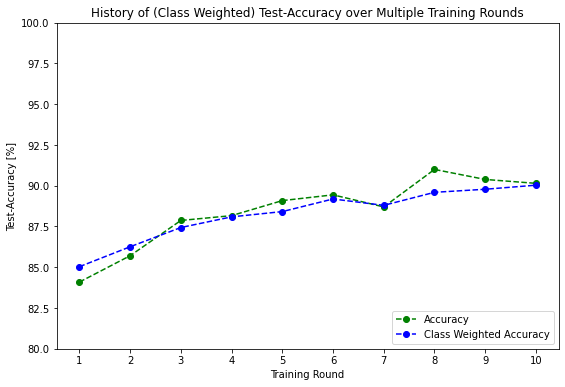

In [206]:
total_accuracies = {1: 0.8409194355939918, 2: 0.8570778334091943, 3: 0.878698224852071, 4: 0.8816568047337278, 5: 0.8908739189804279, 6: 0.894401456531634, 7: 0.8870050068274921, 8: 0.9099908966772872, 9: 0.9038461538461539, 10: 0.9014565316340464}
mean_class_accuracies: {1: 0.85034822776872, 2: 0.8625753762011524, 3: 0.8743673178765344, 4: 0.8809055365205404, 5: 0.8841368864332961, 6: 0.8918688862201104, 7: 0.8879642281327783, 8: 0.8959563865442828, 9: 0.8978331147231927, 10: 0.90032357514288}

rounds = list(total_accuracies.keys())

total_accuracies = np.array(list(total_accuracies))*100
mean_class_accuracies = np.array(list(mean_class_accuracies))*100

plt.figure(figsize=(9,6))
xlabel = "Training Round"
ylabel = "Test-Accuracy [%]"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(f"History of (Class Weighted) Test-Accuracy over Multiple Training Rounds")
plt.xticks(rounds)
plt.ylim(80, 100)

#print(f"Total Accuracies: {global_agent.total_accuracies}")
rounds = list(global_agent.total_accuracies.keys())
total_accuracies = np.array(list(global_agent.total_accuracies.values()))*100
#plt.plot(rounds, total_accuracies)
#print(f"Mean Class Accuracies: {global_agent.mean_class_accuracies}")
rounds = list(global_agent.mean_class_accuracies.keys())
mean_class_accuracies = np.array(list(global_agent.mean_class_accuracies.values()))*100
plt.plot(rounds, total_accuracies, marker='o', linestyle='dashed', color='green', label='Accuracy')
plt.plot(rounds, mean_class_accuracies, marker='o', linestyle='dashed', color='blue', label='Class Weighted Accuracy')
plt.legend(loc ="lower right")
plt.show()

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 3
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
#training_data_strides = split_training_data(train_data, 2)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)
environment_03 = SensorEnvironment(train_data)

from functools import reduce 

sample_distribution_percentages = {
    Behavior.NORMAL: 0,
    Behavior.RANSOMWARE_POC: 20,
    Behavior.ROOTKIT_BDVL: 10,
    Behavior.ROOTKIT_BEURK: 20,
    Behavior.CNC_THETICK: 10, 
    Behavior.CNC_BACKDOOR_JAKORITAR: 20,
    Behavior.CNC_OPT1: 10,
    Behavior.CNC_OPT2: 10
}

sum_of_percentages = reduce(lambda x, y: x+y, sample_distribution_percentages.values())
assert sum_of_percentages == 100, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_03 = Agent(3, input_dims=environment_03.observation_space_size, n_actions=len(environment_03.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)
#client_03 = Client(3, agent_03, environment_03, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)
#server.add_client(client_03)

server.run_federation(evaluations=[Evaluation.TRAINING_TIME, Evaluation.LEARNING_CURVE], evaluation_frequency=1)

In [199]:
from numpy.linalg import norm

N_SAMPLES = 10000

sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.01,
    Behavior.ROOTKIT_BEURK: 0.01,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.01,
    Behavior.CNC_THETICK: 0.2425, 
    Behavior.CNC_OPT1: 0.2425,
    Behavior.CNC_OPT2: 0.2425,
    Behavior.RANSOMWARE_POC: 0.2425
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.32,
    Behavior.ROOTKIT_BEURK: 0.32,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.32,
    Behavior.CNC_THETICK: 0.01, 
    Behavior.CNC_OPT1: 0.01,
    Behavior.CNC_OPT2: 0.01,
    Behavior.RANSOMWARE_POC: 0.01
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")
#print(mean_cosine_similarity(lis))

MID: 0.0046
WCS: 0.7306


In [ ]:
from numpy.linalg import norm

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")
#print(mean_cosine_similarity(lis))

#### 2. Scenario (MID > 0, WCS = 1)

In [ ]:
import math

experiments = Experiment(original_working_directory_path)
experiment_id = 2
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

seed_random()

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.1

N = 1000
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = int(math.ceil(N/NR_ROUNDS))

N_TOTAL = 10000
THRESHOLD = 2000
N_SAMPLES = N_TOTAL - THRESHOLD - 7
N_STRIDES = 15

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

final_training_accuracies = {}
final_mean_class_accuracies = {}

for i in range(N_STRIDES+1):
    fraction = N_SAMPLES/N_STRIDES
    majority = THRESHOLD + math.floor(i*fraction)+1
    minority = math.ceil((N_SAMPLES-i*fraction)/6)+1
    
    print(f"Majority: {majority}; Minority: {minority}")

    sample_matrix = np.array([[majority, minority, minority, minority, minority, minority, minority], [majority, minority, minority, minority, minority, minority, minority]])
    MID = multiclass_imbalance_degree(sample_matrix)
    WCS = weighted_cosine_similarity(sample_matrix)
    
    print(f"Training Dataset with MID: {MID} and WIS: {WCS}")
    
    sampling_probabilities = {
        Behavior.RANSOMWARE_POC: majority/N_TOTAL,
        Behavior.ROOTKIT_BDVL: minority/N_TOTAL,
        Behavior.ROOTKIT_BEURK: minority/N_TOTAL,
        Behavior.CNC_BACKDOOR_JAKORITAR: minority/N_TOTAL,
        Behavior.CNC_THETICK: minority/N_TOTAL, 
        Behavior.CNC_OPT1: minority/N_TOTAL,
        Behavior.CNC_OPT2: minority/N_TOTAL
    }
    
    environment_01 = SensorEnvironment(training_data, sampling_probabilities)
    environment_02 = SensorEnvironment(training_data, sampling_probabilities)

    global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    #print(NR_EPISODES_PER_ROUND)
    server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

    client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
    client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

    server.add_client(client_01)
    server.add_client(client_02)

    server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1, verbose=False)
    final_training_accuracy, final_mean_class_accuracy = server.final_training_accuracy()
    
    final_training_accuracies[MID] = final_training_accuracy
    final_mean_class_accuracies[MID] = final_mean_class_accuracy
    print(f"Final Training Accuracy: {final_training_accuracy}")
    print(f"Final Mean Class Accuracy: {final_mean_class_accuracy}")
    print("----------")

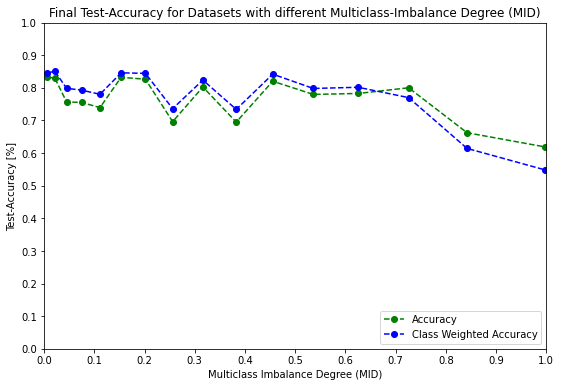

In [122]:
final_training_accuracies = {
    0.0062: 0.8338643604915794,
    0.0216: 0.8289713245334547,
    0.0448: 0.7571051433773327,
    0.0748: 0.7551706873008648,
    0.1113: 0.7395949021392808,
    0.1535: 0.832498862084661,
    0.2018: 0.8264679107874374,
    0.256: 0.6964087391898043,
    0.3162: 0.8026854802002731,
    0.3827: 0.6950295857988166,
    0.4553: 0.8204369594902139,
    0.536: 0.7799271734182976,
    0.6254: 0.7828857532999545,
    0.7259: 0.8002822030040965,
    0.8423: 0.6624578971324533,
    0.9969: 0.6191260810195721
 }

final_mean_class_accuracies = {
    0.0062: 0.8463411655330849,
    0.0216: 0.8503424371389757,
    0.0448: 0.7987394963125322,
    0.0748: 0.7929367758641254,
    0.1113: 0.7803693124076306,
    0.1535: 0.8461062129672096,
    0.2018: 0.8445162424465279,
    0.256: 0.7363210441661953,
    0.3162: 0.8238676090093533,
    0.3827: 0.7339862742852124,
    0.4553: 0.8420964154158485,
    0.536: 0.7981917404477847,
    0.6254: 0.8018314642749663,
    0.7259: 0.7701273877670419,
    0.8423: 0.6143420032537945,
    0.9969: 0.5487733017550455
}


plt.figure(figsize=(9,6))
xlabel = "Multiclass Imbalance Degree (MID)"
ylabel = "Test-Accuracy [%]"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.plot(list(final_training_accuracies.keys()), list(final_training_accuracies.values()), marker='o', linestyle='dashed', color='green', label='Accuracy')
plt.plot(list(final_mean_class_accuracies.keys()), list(final_mean_class_accuracies.values()), marker='o', linestyle='dashed', color='blue', label='Class Weighted Accuracy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc ="lower right")
plt.title(f"Final Test-Accuracy for Datasets with different Multiclass-Imbalance Degree (MID)")
plt.show()

#### 3. Scenario (MID = 0, WCS < 1)

In [84]:
from numpy.linalg import norm

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

final_training_accuracies = {}
final_mean_class_accuracies = {}

N = 1000
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = int(math.ceil(N/NR_ROUNDS))

N_SAMPLES = 10000

baseline_probability = 1/7
lowest_probability = 1/N_SAMPLES
n_strides = 10
frac = (baseline_probability - lowest_probability)/n_strides

for i in range(0, n_strides+1):
    baseline_deviation = i * frac
    inc_probability = baseline_probability + baseline_deviation
    dec_probability = baseline_probability - baseline_deviation
    print(f"i: {i}")
    print(f"inc_probability: {inc_probability}")
    print(f"dec_probability: {dec_probability}")

    sampling_probabilities_1 = {
        #Behavior.NORMAL: 0,
        Behavior.RANSOMWARE_POC: inc_probability,
        Behavior.ROOTKIT_BDVL: inc_probability,
        Behavior.ROOTKIT_BEURK: inc_probability,
        Behavior.CNC_THETICK: baseline_probability, 
        Behavior.CNC_OPT1: dec_probability,
        Behavior.CNC_OPT2: dec_probability,
        Behavior.CNC_BACKDOOR_JAKORITAR: dec_probability,
    }

    sampling_probabilities_2 = {
        #Behavior.NORMAL: 0,
        Behavior.RANSOMWARE_POC: dec_probability, 
        Behavior.ROOTKIT_BDVL: dec_probability,
        Behavior.ROOTKIT_BEURK: dec_probability,
        Behavior.CNC_THETICK: baseline_probability, 
        Behavior.CNC_OPT1: inc_probability,
        Behavior.CNC_OPT2: inc_probability,
        Behavior.CNC_BACKDOOR_JAKORITAR: inc_probability,
    }

    n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
    n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

    sample_matrix = np.vstack([n_samples_1, n_samples_2])
    
    MID = multiclass_imbalance_degree(sample_matrix)
    WCS = weighted_cosine_similarity(sample_matrix)

    print(f"MID: {MID}")
    print(f"WCS: {WCS}")
    
    environment_01 = SensorEnvironment(training_data, sampling_probabilities_1)
    environment_02 = SensorEnvironment(training_data, sampling_probabilities_2)

    global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    #print(NR_EPISODES_PER_ROUND)
    server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

    client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
    client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

    server.add_client(client_01)
    server.add_client(client_02)

    server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1, verbose=False)
    final_training_accuracy, final_mean_class_accuracy = server.final_training_accuracy()
    
    final_training_accuracies[WCS] = final_training_accuracy
    final_mean_class_accuracies[WCS] = final_mean_class_accuracy
    print(f"Final Training Accuracy: {final_training_accuracy}")
    print(f"Final Mean Class Accuracy: {final_mean_class_accuracy}")
    print("----------")

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
i: 0
inc_probability: 0.14285714285714285
dec_probability: 0.14285714285714285
MID: 0.0
WCS: 1.0
Final Training Accuracy: 0.8414883932635412
Final Mean Class Accuracy: 0.8535800693743356
----------
i: 1
inc_probability: 0.15713285714285713
dec_probability: 0.12858142857142857
MID: 0.0
WCS: 0.9957
Final Training Accuracy: 0.8359126081019572
Final Mean Class Accuracy: 0.8549514540206962
----------
i: 2
inc_probability: 0.1714085714285714
dec_probability: 0.11430571428571427
MID: 0.0
WCS: 0.9833
Final Training Accuracy: 0.8371643149749659
Final Mean Class Accuracy: 0.8476238420368423
----------
i: 3
inc_probability: 0.1856842857142857
dec_probability: 0.10003
MID: 0.0
WCS: 0.9636
Final Training Accuracy: 0.8373918980427856
Final Mean Class Accuracy: 0.8510202432786078
----------
i: 4
inc_probability: 0.19996
dec_probability: 0.0857542857142857
MID: 0.0
WCS: 0.9378
Final Training Accuracy: 0.627446517979062

In [105]:
final_mean_class_accuracies

{1.0: 0.8535800693743356,
 0.9957: 0.8549514540206962,
 0.9833: 0.8476238420368423,
 0.9636: 0.8510202432786078,
 0.9378: 0.8023259371459674,
 0.9076: 0.852032852524513,
 0.8743: 0.7968542241714783,
 0.8394: 0.8434679960919038,
 0.8038: 0.7101254347289291,
 0.7685: 0.6983170899055311,
 0.734: 0.5421828417610298}

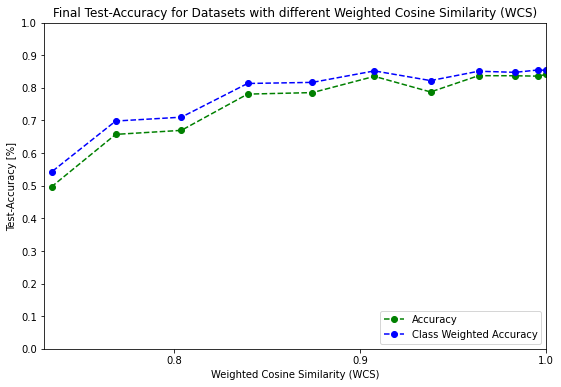

In [121]:
final_training_accuracies = {
    1.0: 0.8414883932635412,
    0.9957: 0.8359126081019572,
    0.9833: 0.8371643149749659,
    0.9636: 0.8373918980427856,
    0.9378: 0.7874465179790624,
    0.9076: 0.8353436504324079,
    0.8743: 0.7855120619025945,
    0.8394: 0.7808921256258535,
    0.8038: 0.6697086936731907,
    0.7685: 0.657419208010924,
    0.734: 0.49670004551661356
}

final_mean_class_accuracies = {
    1.0: 0.8535800693743356,
    0.9957: 0.8549514540206962,
    0.9833: 0.8476238420368423,
    0.9636: 0.8510202432786078,
    0.9378: 0.8223259371459675,
    0.9076: 0.852032852524513,
    0.8743: 0.8168542241714783,
    0.8394: 0.8134679960919038,
    0.8038: 0.7101254347289291,
    0.7685: 0.6983170899055311,
    0.734: 0.5421828417610298
}

plt.figure(figsize=(9,6))
xlabel = "Weighted Cosine Similarity (WCS)"
ylabel = "Test-Accuracy [%]"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.plot(list(final_training_accuracies.keys()), list(final_training_accuracies.values()), marker='o', linestyle='dashed', color='green', label='Accuracy')
plt.plot(list(final_mean_class_accuracies.keys()), list(final_mean_class_accuracies.values()), marker='o', linestyle='dashed', color='blue', label='Class Weighted Accuracy')
plt.xlim([0.73,1])
plt.ylim([0, 1])
plt.legend(loc ="lower right")
plt.title(f"Final Test-Accuracy for Datasets with different Weighted Cosine Similarity (WCS)")
plt.show()

#### 4. Scenario (MID > 0, WCS < 1)

In [77]:
from numpy.linalg import norm

N_SAMPLES = 10000

sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.45,
    Behavior.ROOTKIT_BEURK: 0.45,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.0001,
    Behavior.CNC_THETICK: 0.0001, 
    Behavior.CNC_OPT1: 0.0001,
    Behavior.CNC_OPT2: 0.0001,
    Behavior.RANSOMWARE_POC: 0.0001
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 0.0001,
    Behavior.ROOTKIT_BEURK: 0.0001,
    Behavior.CNC_BACKDOOR_JAKORITAR: 0.45,
    Behavior.CNC_THETICK: 0.45, 
    Behavior.CNC_OPT1: 0.0001,
    Behavior.CNC_OPT2: 0.0001,
    Behavior.RANSOMWARE_POC: 0.0001
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")

MID: 0.2861
WCS: 0.7073


-----------
### Experiment 03

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 3
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
NR_ROUNDS = 10
N_SAMPLES = 10000

seed_random()

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")

environment_01 = SensorEnvironment(training_data, sampling_probabilities_1)
environment_02 = SensorEnvironment(training_data, sampling_probabilities_2)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.TRAINING_TIME, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)


-----------
#### Experiment 04

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 4
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
NR_ROUNDS = 10


seed_random()

full_train_data, full_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK)
subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1, Behavior.CNC_OPT2)
sub_train_1 = {x: full_train_data[x] for x in subset_1 if x in full_train_data}
sub_train_2 = {x: full_train_data[x] for x in subset_2 if x in full_train_data}

environment_01 = SensorEnvironment(sub_train_1)
environment_02 = SensorEnvironment(sub_train_2)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE], evaluation_frequency=1)

-----------
#### Experiment 05

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 5
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

seed_random()

full_train_data, full_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.CNC_OPT1)
subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.ROOTKIT_BEURK , Behavior.CNC_OPT2, Behavior.CNC_BACKDOOR_JAKORITAR)
sub_train_1 = {x: full_train_data[x] for x in subset_1 if x in full_train_data}
sub_train_2 = {x: full_train_data[x] for x in subset_2 if x in full_train_data}

environment_01 = SensorEnvironment(sub_train_1)
environment_02 = SensorEnvironment(sub_train_2)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC, is_global_agent=True)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE], evaluation_frequency=1)

-----------
### Experiment 06

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 6
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)


seed_random()
start = time()

full_train_data, full_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1)
subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.ROOTKIT_BEURK , Behavior.CNC_OPT2)
sub_train_1 = {x: full_train_data[x] for x in subset_1 if x in full_train_data}
sub_train_2 = {x: full_train_data[x] for x in subset_2 if x in full_train_data}

environment_01 = SensorEnvironment(sub_train_1)
environment_02 = SensorEnvironment(sub_train_2)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC, is_global_agent=True)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)


server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)
# initialize memory replay buffer (randomly)
client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE], evaluation_frequency=1)


-----------
### Experiment 07

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 7
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 100
NR_EPISODES_PER_ROUND=100

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION])

-----------
#### Experiment 8.1

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 8
experiment_version = 1
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)


NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    server.add_client(client)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE], evaluation_frequency=1)

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 8
experiment_version = 2
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI, normal_only=True)
environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)



for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    server.add_client(client)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE], evaluation_frequency=1)

-----------
#### Experiment 09

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 9
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 100
NR_EPISODES_PER_ROUND=100
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI, normal_only=True)
environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)



for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    server.add_client(client)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE], evaluation_frequency=10)

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 10
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 100
NR_EPISODES_PER_ROUND=100
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

for behavior in Behavior:
    print(str(behavior).split('.')[1])

for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    client.plot_training_data_split()
    server.add_client(client)

server.run_federation(evaluations=[Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE], evaluation_frequency=10)